In [ ]:
!pip install mne

In [ ]:
!pip install -q gwpy

In [ ]:
import mne
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Utility dictionarys**

In [ ]:
# divide elctrodes from EEG device to three parts
electrodes = {"central": ['EEG F3-Cz', 'EEG F4-Cz', 'EEG Fz-Cz', 'EEG C3-Cz', 
                          'EEG C4-Cz', 'EEG P3-Cz', 'EEG P4-Cz', 'EEG Pz-Cz'],
              "frontal": ['EEG Fp1-Cz', 'EEG Fp2-Cz', 'EEG F7-Cz', 'EEG F3-Cz', 
                          'EEG Fz-Cz', 'EEG F4-Cz', 'EEG F8-Cz'],
              "temporal": ['EEG T3-Cz', 'EEG T4-Cz', 'EEG T5-Cz', 'EEG T6-Cz']}

# dictionary to get number data from control experiment
results = {
    'frontal': {'eyes': {}, 'experiment': {}},
    'central': {'eyes': {}, 'experiment': {}},
    'temporal': {'eyes': {}, 'experiment': {}},
}

# dictionary to get number data from music experiment
results_music = {
    'frontal': {'eyes': {}, 'experiment': {}},
    'central': {'eyes': {}, 'experiment': {}},
    'temporal': {'eyes': {}, 'experiment': {}},
}

# dictionary for calculating Event Related Desynchronization to 
# measure bands power for control experiment
erd = {
    'frontal': {},
    'central': {},
    'temporal': {},
}

# dictionary for calculating Event Related Desynchronization to 
# measure bands power for music experiment
erd_music = {
    'frontal': {},
    'central': {},
    'temporal': {},
}

experiment_parts = ['eyes', 'experiment']

bands = ['alpha', 'theta', 'beta']

In [ ]:
!pip install PyDrive

**Part to download experiments data from Google Drive**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**CONTROL PART** 



 #### Download edf files of control data<br>
 EDF files was splitted by next events: <br>
  - calibration with opened eyes
  - calibration with closed eyes
  - solving first task
  - solving second task <br>
  Tasks was solved without music


In [ ]:
# calibration with closed eyes part
downloaded = drive.CreateFile({'id':'1IIrOEROGf9FqtIRTOBkxXMXzlxGKbvjY'})
control_rest_closed = 'DmitriiPolushin.Internship2020.EyesClosed.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.EyesClosed.edf')

# calibration with opened eyes part
downloaded = drive.CreateFile({'id':'1cCLpf28Dp0qtVuSGpvdyn8QpikhBIHeP'})
control_rest_opened = 'DmitriiPolushin.Internship2020.EyesOpened.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.EyesOpened.edf')

# solving first task part
downloaded = drive.CreateFile({'id':'1C2qDfiBao83kfOVhCV1UZRTJxQVRkpmd'})
control_exp_first = 'DmitriiPolushin.Internship2020.FirstTask.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.FirstTask.edf')

# solving second task part
downloaded = drive.CreateFile({'id':'1z3MVlsJMyB771ibfNzBtGvhK2UMWOAkD'})
control_exp_second = 'DmitriiPolushin.Internship2020.SecondTask.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.SecondTask.edf')

# perform edf fiels to raw arrays
control_raw_rest_closed = mne.io.read_raw_edf(control_rest_closed, preload=True)
control_raw_rest_opened = mne.io.read_raw_edf(control_rest_opened, preload=True)
control_raw_exp_first = mne.io.read_raw_edf(control_exp_first, preload=True)
control_raw_exp_second = mne.io.read_raw_edf(control_exp_second, preload=True)

Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.EyesClosed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30499  =      0.000 ...   121.996 secs...
Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.EyesOpened.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 32999  =      0.000 ...   131.996 secs...
Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.FirstTask.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 375249  =      0.000 ...  1500.996 secs...
Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.SecondTask.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 368749  =      0.000 ...  1474.996 secs...


In [ ]:
sfreq = control_raw_exp_first.info['sfreq']

- Function to divide data to bands according to frequency 

In [ ]:
def create_sub_bands(data):
  return {
      'alpha': mne.filter.filter_data(data=np.mean(data.get_data(), axis=0), 
                                      l_freq=8,
                                      h_freq=12, 
                                      sfreq=sfreq, 
                                      method="fir"),
      'theta': mne.filter.filter_data(data=np.mean(data.get_data(), axis=0), 
                                      l_freq=4,
                                      h_freq=8, 
                                      sfreq=sfreq, 
                                      method="fir"),
      'beta': mne.filter.filter_data(data=np.mean(data.get_data(), axis=0),
                                      l_freq=12,
                                      h_freq=30, 
                                      sfreq=sfreq, 
                                      method="fir"),
      }

- function fot executing raw arrays to get number data and use notch filter to cut high frequency

In [ ]:
%%capture
def create_data_from_raw(rawdata, area):

  rawdata_pick = rawdata.copy().pick_channels(ch_names=electrodes[area])

  rawdata_filtered_data = mne.filter.notch_filter(x=rawdata_pick.get_data(),
                                                  Fs=sfreq, 
                                                  freqs=[50, 100]
                                                  )

  rawdata_filtered = mne.io.RawArray(data=rawdata_filtered_data,
                                     info=mne.create_info(ch_names=electrodes[area], 
                                                          sfreq=sfreq)
                                     )
  
  return create_sub_bands(rawdata_filtered)

- create number data for every event

In [ ]:
%%capture
for area in electrodes:
  results[area]['eyes']['opened'] = create_data_from_raw(control_raw_rest_opened, area)
  results[area]['eyes']['closed'] = create_data_from_raw(control_raw_rest_closed, area)
  results[area]['experiment']['first'] = create_data_from_raw(control_raw_exp_first, area)
  results[area]['experiment']['second'] = create_data_from_raw(control_raw_exp_second, area)

- function to calculate Event Related Desynchronization

In [ ]:
def ERD(rest, task):
    print(rest, task)
    return (rest-task) / rest * 100

- Function to prepare pandas DataFrame for plotting graphs

In [ ]:
def create_dataFrame(experiment, eyes):
  data_for_frame = []
  for area in results:
    el = []
    for band in bands:
      rest = np.mean(results[area]['eyes'][eyes][band], axis=0) * np.power(10, 6)
      task = np.mean(results[area]['experiment'][experiment][band], axis=0) * np.power(10, 6)
      erd[area][band] = ERD(rest, task)        
      el.append(erd[area][band])      
    data_for_frame.append(el)
  return pd.DataFrame(data_for_frame, columns=erd['central'].keys(), index=erd.keys())

In [ ]:
# create dataFrame for each event 
open_eyes_first_task = create_dataFrame('first', 'opened')
open_eyes_second_task = create_dataFrame('second', 'opened')
closed_eyes_first_task = create_dataFrame('first', 'closed')
closed_eyes_second_task = create_dataFrame('second', 'closed')

7.122507484008057e-05 -6.628200057072728e-05
-0.0007180976546535407 -1.0880875227530962e-05
1.3990953745106773e-05 3.5871914055132594e-06
-0.00017347813280294065 -5.269579501109344e-05
-0.00030752257361474204 3.622092877099074e-05
2.0160642646659402e-05 -2.879217531195294e-05
-2.8479825671692604e-05 -0.00012619061112137834
0.0009663298026326182 -4.123027726330413e-06
-5.591271723530982e-05 -2.9175044800476576e-06
7.122507484008057e-05 -6.0364850126960744e-05
-0.0007180976546535407 -0.00027178532872276784
1.3990953745106773e-05 -1.773367631295379e-06
-0.00017347813280294065 -2.5206667030396367e-05
-0.00030752257361474204 -0.00013663542973606945
2.0160642646659402e-05 1.3009327168504533e-05
-2.8479825671692604e-05 -4.4471785326276775e-05
0.0009663298026326182 -0.00020160950827878936
-5.591271723530982e-05 5.211911235075008e-05
-0.0003692865209434007 -6.628200057072728e-05
0.001373029016572857 -1.0880875227530962e-05
-0.00040856304529590735 3.5871914055132594e-06
0.0005251686804062236 -5.

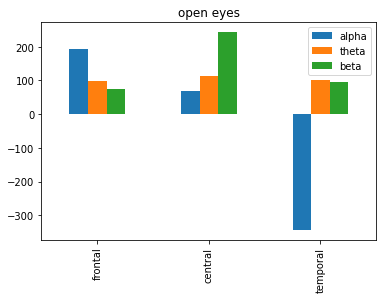

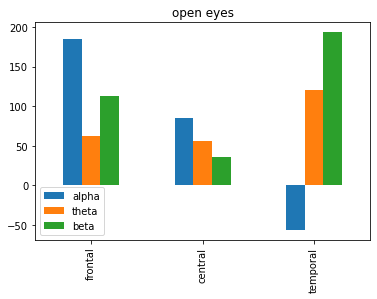

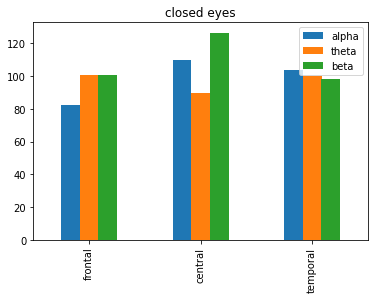

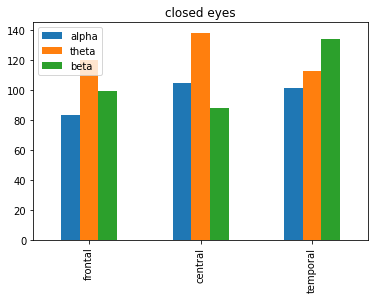

In [ ]:
open_eyes_first_task.plot(kind='bar', title='open eyes')
open_eyes_second_task.plot(kind='bar', title='open eyes')
closed_eyes_first_task.plot(kind='bar', title='closed eyes')
closed_eyes_second_task.plot(kind='bar', title='closed eyes')

### **Some conclusions** <br>
As we can see if we calculate EDF using rest data with open eyes alpha band in temporal part of our brain is going strange<br>
But with calibration with closed all looks normal <br>
In article *EEG alpha and theta oscillations reflect cognitive and memory performance a review and analysis and Understanding Programming Expertise* was the same result. If we will see on the part with closed eyes calibration then while solving task the theta power is increase and alpha power is decrease <br>
Also the power of alpha band with closed eyes in frontal part (region where most of your conscious thoughts and decisions are made) is much smaller then with open eyes
 

## **MUSIC PART** 

**The same that we have with Control part**

In [ ]:
downloaded = drive.CreateFile({'id':'1Ne_7yQE2q8akT0ZYsW48FhxjjiAE031c'})
music_rest_closed = 'DmitriiPolushin.Internship2020.EyesClosed.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.EyesClosed.edf')

downloaded = drive.CreateFile({'id':'17XiMyXkj1U6jCVum_GfCoO4G0Ms_a7dg'})
music_rest_opened = 'DmitriiPolushin.Internship2020.EyesOpened.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.EyesOpened.edf')

downloaded = drive.CreateFile({'id':'1NKbwbmYdDcxQ6DfqEGWhBPRiYOA1lQku'})
music_exp_first = 'DmitriiPolushin.Internship2020.FirstTask.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.FirstTask.edf')

downloaded = drive.CreateFile({'id':'1gK24CpJsc9BgNtdIqUbSJwZAn6j5hOjI'})
music_exp_second = 'DmitriiPolushin.Internship2020.SecondTask.edf'
downloaded.GetContentFile('DmitriiPolushin.Internship2020.SecondTask.edf')

music_raw_rest_closed = mne.io.read_raw_edf(music_rest_closed, preload=True)
music_raw_rest_opened = mne.io.read_raw_edf(music_rest_opened, preload=True)
music_raw_exp_first = mne.io.read_raw_edf(music_exp_first, preload=True)
music_raw_exp_second = mne.io.read_raw_edf(music_exp_second, preload=True)

Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.EyesClosed.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...   123.996 secs...
Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.EyesOpened.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 46999  =      0.000 ...   187.996 secs...
Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.FirstTask.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 252499  =      0.000 ...  1009.996 secs...
Extracting EDF parameters from /content/DmitriiPolushin.Internship2020.SecondTask.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296999  =      0.000 ...  1187.996 secs...


In [ ]:
sfreq = music_raw_exp_first.info['sfreq']

In [ ]:
%%capture

for area in electrodes:
  results_music[area]['eyes']['opened'] = create_data_from_raw(music_raw_rest_opened, area)
  results_music[area]['eyes']['closed'] = create_data_from_raw(music_raw_rest_closed, area)
  results_music[area]['experiment']['first'] = create_data_from_raw(music_raw_exp_first, area)
  results_music[area]['experiment']['second'] = create_data_from_raw(music_raw_exp_second, area)

In [ ]:
def create_music_dataFrame(experiment, eyes):
  data_for_frame = []
  for area in results:
    el = []
    for band in bands:
      rest = np.mean(results_music[area]['eyes'][eyes][band], axis=0) * np.power(10, 6)
      task = np.mean(results_music[area]['experiment'][experiment][band], axis=0) * np.power(10, 6)
      erd[area][band] = ERD(rest, task)        
      el.append(erd[area][band])      
    data_for_frame.append(el)
  print(erd)
  return pd.DataFrame(data_for_frame, columns=erd['central'].keys(), index=erd.keys())

In [ ]:
music_open_eyes_first_task = create_music_dataFrame('first', 'opened')
music_open_eyes_second_task = create_music_dataFrame('second', 'opened')
music_closed_eyes_first_task = create_music_dataFrame('first', 'closed')
music_closed_eyes_second_task = create_music_dataFrame('second', 'closed')

4.628225769525872e-05 -4.1196339753515284e-06
-0.0004246217545831754 0.0004612536101344302
-0.00043973293929265366 4.991110635717486e-06
0.00019647708162120523 1.3151966843851077e-06
-0.0007265508380322451 0.0005118875814219424
-3.718772875439672e-05 1.6250416554537576e-05
0.0004180443036498087 9.173534683989376e-05
0.0008557016468888799 -0.00010305260290702947
-0.0005035122914388673 4.259248692956706e-06
{'frontal': {'alpha': 108.9011085035585, 'theta': 208.62693801150485, 'beta': 101.13503224110207}, 'central': {'alpha': 99.33061063736649, 'theta': 170.454475396149, 'beta': 143.69833033327234}, 'temporal': {'alpha': 78.05607060328718, 'theta': 112.04305300588157, 'beta': 100.84590759061416}}
new
4.628225769525872e-05 3.730509046453783e-05
-0.0004246217545831754 0.000152569647855588
-0.00043973293929265366 2.4958062610591645e-05
0.00019647708162120523 1.5003606146381733e-05
-0.0007265508380322451 0.00018582103703755162
-3.718772875439672e-05 2.0068582910509983e-05
0.000418044303649808

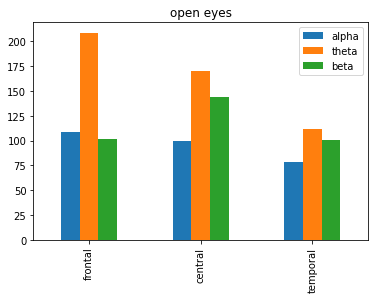

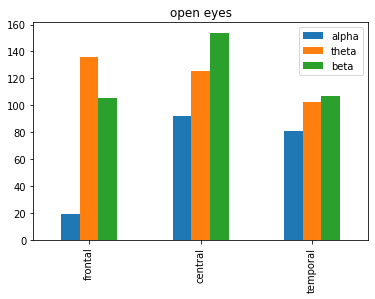

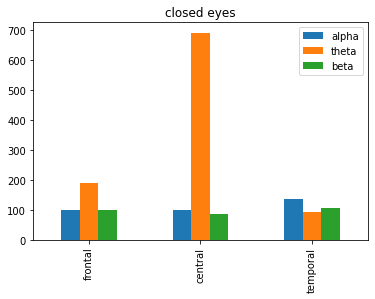

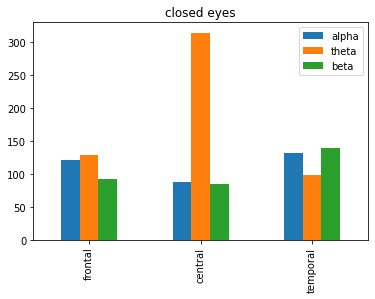

In [ ]:
music_open_eyes_first_task.plot(kind='bar', title='open eyes')
music_open_eyes_second_task.plot(kind='bar', title='open eyes')
music_closed_eyes_first_task.plot(kind='bar', title='closed eyes')
music_closed_eyes_second_task.plot(kind='bar', title='closed eyes')

#### ERD with closed eyes
- Very high desynchronization of theta band in central part of brain <br>


#### ERD with open eyes
- Big difference between alpha and theta bands in frontal parts